In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats

from linearmodels import PanelOLS

In [369]:
df = pd.read_csv('data/KLD_Compustat_keep.csv', dtype={'gvkey': str, 'sic': str})

In [370]:
df.shape

(43331, 99)

In [371]:
df.columns

Index(['ticker_KLD', 'cusip_KLD', 'companyname', 'year', 'date', 'permno',
       'gvkey', 'datadate', 'fyear', 'cusip', 'ticker', 'companyid', 'size',
       'lev', 'b_mkt', 'rdi', 'adi', 'sale', 'cogs', 'ppegt', 'xsga', 'xlr',
       'emp', 'xad', 'xrd', 'at', 'sich', 'ppent', 'aqc', 'capx', 'capxv',
       'gpm', 'npm', 'roa', 'roe', 'bm', 'evm', 'pe_exi', 'pe_inc', 'pe_ib',
       'pe_ni', 'rd_sale', 'adv_sale', 'xsga_sale', 'markup_acct',
       'market_sale', 'div_sale', 'markup', 'markup_overhead', 'econ_profit',
       'profit_rate', 'op_profit_rate', 'econ_roa', 'positive', 'negative',
       'positive_avg', 'negative_avg', 'KLDIndex', 'KLDIndexNorm', 'E_pos',
       'E_neg', 'E Index', 'S_pos', 'S_neg', 'S Index', 'G_pos', 'G_neg',
       'G Index', 'ControvIndex', 'COM_pos', 'COM_neg', 'ESG_COM', 'DIV_pos',
       'DIV_neg', 'ESG_DIV', 'EMP_pos', 'EMP_neg', 'ESG_EMP', 'ENV_pos',
       'ENV_neg', 'ESG_ENV', 'HUM_pos', 'HUM_neg', 'ESG_HUM', 'PRO_pos',
       'PRO_neg', 'ESG_P

Lists of dependent and independent variables:

In [372]:
KLD_list = ['positive', 'negative', 'positive_avg', 'negative_avg', # positive, negative, averages
            'KLDIndex', 'KLDIndexNorm',                             # ESG Aggregate Index included controversial, and normalized
            'E_pos', 'E_neg', 'E Index',                            # Environmental aggregate
            'S_pos', 'S_neg', 'S Index',                            # Social aggregate
            'G_pos', 'G_neg', 'G Index',                            # Governance aggregate
            'ControvIndex',                                         # Controversial aggregate
            'COM_pos', 'COM_neg', 'ESG_COM',                        # Community
            'DIV_pos', 'DIV_neg', 'ESG_DIV',                        # Diversity
            'EMP_pos', 'EMP_neg', 'ESG_EMP',                        # Employee relations
            'ENV_pos', 'ENV_neg', 'ESG_ENV',                        # Environment
            'HUM_pos', 'HUM_neg', 'ESG_HUM',                        # Human rights
            'PRO_pos', 'PRO_neg', 'ESG_PRO',                        # Product Quality
            'CGOV_pos', 'CGOV_neg', 'ESG_CGOV',                     # Corporate Governance
            'ESG_A_ex_CG_pos', 'ESG_A_ex_CG_neg', 'ESGxGIndex',     # ESG Aggregate excluded Corporate Governance
            'ESG_A_pos', 'ESG_A_neg', 'ESGIndex']                   # ESG Aggregate included Corporate Governance

In [373]:
Comp_level_list = ['sale', 'cogs', 'ppegt', 'xsga', 'xlr', 'emp', 'xad', # Compustat level variables
                   'xrd', 'at', 'sich', 'ppent', 'aqc', 'capx', 'capxv']

In [374]:
Comp_ratio_list = ['gpm', 'npm', 'roa', 'roe',                        # Profitability ratios
                   'bm', 'evm', 'pe_exi', 'pe_inc', 'pe_ib', 'pe_ni', # Valuation ratios
                   'rd_sale', 'adv_sale', 'xsga_sale',                # R&D, Ads, SG&A to sales ratios
                   'markup_acct', 'market_sale', 'div_sale',          # Sales to COGS, Market Value share of Sales & Dividends share of Sales
                   'markup', 'markup_overhead', 'econ_profit', 'profit_rate', 'op_profit_rate', 'econ_roa'] # Production-based Markups & Profit rates as a measure of market power

In [375]:
Control_list = ['size', 'lev', 'b_mkt', 'rdi', 'adi'] # log(assets), leverage: the ratio of total debt to the market value of equity, beta, R&D intensity, ads intensity

In [376]:
len(KLD_list) + len(Comp_level_list) + len(Comp_ratio_list) + len(Control_list)

84

In [377]:
df = df[df['sale']>0]

In [378]:
df.shape

(43063, 99)

In [379]:
len(df[(df['sic']>=4900) & (df['sic']<5000)])

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
len(df[(df['sic']>=6000) & (df['sic']<7000)])

In [ ]:
len(df[(df['aqc']>0.05*df['at'])])

***To avoid firms with strange production functions, drop regulated utilities and financial companies, i.e., drop if the 4-digit sic code is in the range [4900,5000) or [6000,7000).

In [ ]:
#df = df[~(((df['sic']>=4900) & (df['sic']<5000)) | ((df['sic']>=6000) & (df['sic']<7000)))]

In [380]:
df.shape

(43063, 99)

In [381]:
def wins(s):
    return mstats.winsorize(s, limits=[0.01, 0.01])

In [382]:
df.sale[df.fyear==2015].describe()

count      2082.000000
mean       6334.114761
std       20552.854308
min           0.061000
25%         468.781500
50%        1370.602000
75%        4162.933000
max      479962.000000
Name: sale, dtype: float64

In [383]:
pd.Series(wins(df.sale[df.fyear==2015])).describe()

count      2082.000000
mean       5746.229244
std       14384.649660
min           5.653000
25%         468.781500
50%        1370.602000
75%        4162.933000
max      101751.800000
dtype: float64

In [384]:
df[['sale','fyear']].groupby('fyear')['sale'].transform(wins)[df.fyear==2015].describe()

count      2082.000000
mean       5746.229244
std       14384.649660
min           5.653000
25%         468.781500
50%        1370.602000
75%        4162.933000
max      101751.800000
Name: sale, dtype: float64

In [385]:
df[['sale','fyear']].groupby('fyear')['sale'].transform(wins).describe()

count     43063.000000
mean       4561.564519
std       10767.785276
min           2.026000
25%         329.373500
50%        1071.849000
75%        3612.358500
max      101751.800000
Name: sale, dtype: float64

In [386]:
pd.Series(wins(df.sale)).describe()

count    43063.000000
mean      4524.985295
std      10375.984498
min          5.535000
25%        329.373500
50%       1071.849000
75%       3612.358500
max      71633.000000
dtype: float64

In [387]:
df.sale.describe()

count     43063.000000
mean       5145.955116
std       16871.307116
min           0.010000
25%         329.373500
50%        1071.849000
75%        3612.358500
max      483521.000000
Name: sale, dtype: float64

Descriptive statistics of KLD variables

AxesSubplot(0.125,0.125;0.775x0.755)


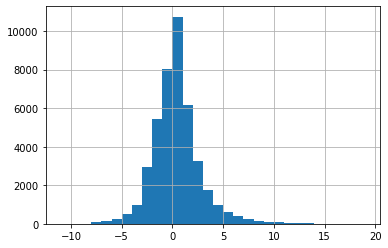

In [388]:
print(df['ESGIndex'].hist(bins=30))

In [389]:
for var in KLD_list:
    print(var.upper() + ' Summary\n'+ str(df[var].describe()) + '\n')

POSITIVE Summary
count    43063.000000
mean         1.513550
std          2.267665
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         22.000000
Name: positive, dtype: float64

NEGATIVE Summary
count    43063.000000
mean         1.694657
std          1.873601
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         18.000000
Name: negative, dtype: float64

POSITIVE_AVG Summary
count    43020.000000
mean         0.061966
std          0.101723
min          0.000000
25%          0.000000
50%          0.026316
75%          0.078947
max          1.000000
Name: positive_avg, dtype: float64

NEGATIVE_AVG Summary
count    43063.000000
mean         0.047570
std          0.052535
min          0.000000
25%          0.000000
50%          0.027778
75%          0.075000
max          0.533333
Name: negative_avg, dtype: float64

KLDINDEX Summary
count    43063.000000
mean        -0.181107
std          2.431604
m

Descriptive statistics of Compustat level variables

In [390]:
for var in Comp_level_list:
    print(var.upper() + ' & winsorized Summary\n'+ str(df[var].describe()) + '\n' + str(pd.Series(wins(df[var])).describe()) +'\n')

SALE & winsorized Summary
count     43063.000000
mean       5145.955116
std       16871.307116
min           0.010000
25%         329.373500
50%        1071.849000
75%        3612.358500
max      483521.000000
Name: sale, dtype: float64
count    43063.000000
mean      4524.985295
std      10375.984498
min          5.535000
25%        329.373500
50%       1071.849000
75%       3612.358500
max      71633.000000
dtype: float64

COGS & winsorized Summary
count     43063.00000
mean       3424.88892
std       12470.16870
min        -669.21800
25%         151.61750
50%         612.80000
75%        2262.65850
max      355913.00000
Name: cogs, dtype: float64
count    43063.000000
mean      2920.260102
std       6965.776990
min          5.490000
25%        151.617500
50%        612.800000
75%       2262.658500
max      48650.000000
dtype: float64

PPEGT & winsorized Summary
count     38656.000000
mean       3733.981096
std       14153.156495
min           0.000000
25%         116.198000
50%     

Descriptive statistics of Compustat ratio variables

In [391]:
for var in Comp_ratio_list:
    print(var.upper() + ' & winsorized Summary\n'+ str(df[var].describe()) + '\n' + str(pd.Series(wins(df[var])).describe()) +'\n')

GPM & winsorized Summary
count    43063.000000
mean        -2.007729
std        164.752981
min     -29325.700000
25%          0.231097
50%          0.379131
75%          0.583231
max          2.117325
Name: gpm, dtype: float64
count    43063.000000
mean         0.338307
std          0.621714
min         -4.607493
25%          0.231097
50%          0.379131
75%          0.583231
max          0.937562
dtype: float64

NPM & winsorized Summary
count    43063.000000
mean        -2.729566
std        168.076489
min     -29319.000000
25%          0.012666
50%          0.055398
75%          0.110658
max         68.516340
Name: npm, dtype: float64
count    43063.000000
mean        -0.095895
std          0.963999
min         -8.185920
25%          0.012666
50%          0.055398
75%          0.110658
max          0.384652
dtype: float64

ROA & winsorized Summary
count    43063.000000
mean         0.100133
std          0.176807
min        -12.412666
25%          0.047785
50%          0.110635
75%  

Descriptive statistics of control variables

In [392]:
for var in Control_list:
    print(var.upper() + ' & winsorized Summary\n'+ str(df[var].describe()) + '\n' + str(pd.Series(wins(df[var])).describe()) +'\n')

SIZE & winsorized Summary
count    43063.000000
mean         7.519840
std          1.799969
min         -0.021224
25%          6.233882
50%          7.418705
75%          8.650697
max         14.760632
Name: size, dtype: float64
count    43063.000000
mean         7.517359
std          1.762390
min          3.847548
25%          6.233882
50%          7.418705
75%          8.650697
max         12.263067
dtype: float64

LEV & winsorized Summary
count    4.286100e+04
mean     8.523564e+01
std      1.421061e+04
min     -4.580280e-02
25%      4.011886e-02
50%      2.145987e-01
75%      5.925188e-01
max      2.886261e+06
Name: lev, dtype: float64
count    43063.000000
mean         0.657890
std          1.601930
min          0.000000
25%          0.040871
50%          0.216696
75%          0.601284
max         12.628720
dtype: float64

B_MKT & winsorized Summary
count    41317.000000
mean         1.222668
std          0.800161
min         -9.065500
25%          0.683000
50%          1.099600
7

In [393]:
sum(df['adi']<0)

0

In [394]:
sum(pd.Series(wins(df['adi']))<0)

0

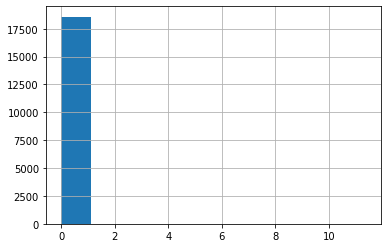

In [395]:
df['adi'].hist()

In [396]:
(df['adi'].notna() & df['rdi'].notna()).sum()

10358

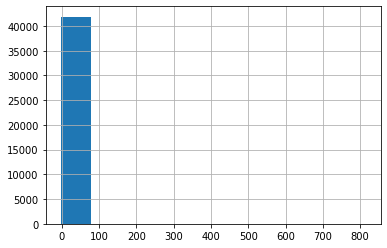

In [397]:
pd.Series(wins(df['roe'])).hist()

# Winsorize by year

In [398]:
df_wins = df.copy() # make a copy

In [399]:
for var in Comp_ratio_list:
    df_wins[var] = df[[var,'fyear']].groupby('fyear')[var].transform(wins)

for var in Control_list:
    df_wins[var] = df[[var,'fyear']].groupby('fyear')[var].transform(wins)

In [400]:
df_wins.shape

(43063, 99)

In [401]:
for var in Comp_ratio_list:
    print(var.upper() + ' & winsorized Summary\n'+ str(df[var].describe()) + '\n' + str(df_wins[var].describe()) +'\n')

GPM & winsorized Summary
count    43063.000000
mean        -2.007729
std        164.752981
min     -29325.700000
25%          0.231097
50%          0.379131
75%          0.583231
max          2.117325
Name: gpm, dtype: float64
count    43063.000000
mean         0.312344
std          0.913199
min        -18.253758
25%          0.231097
50%          0.379131
75%          0.583231
max          0.969802
Name: gpm, dtype: float64

NPM & winsorized Summary
count    43063.000000
mean        -2.729566
std        168.076489
min     -29319.000000
25%          0.012666
50%          0.055398
75%          0.110658
max         68.516340
Name: npm, dtype: float64
count    43063.000000
mean        -0.139767
std          1.564152
min        -42.811860
25%          0.012666
50%          0.055398
75%          0.110658
max          0.520323
Name: npm, dtype: float64

ROA & winsorized Summary
count    43063.000000
mean         0.100133
std          0.176807
min        -12.412666
25%          0.047785
50%  

In [402]:
for var in Control_list:
    print(var.upper() + ' & winsorized Summary\n'+ str(df[var].describe()) + '\n' + str(df_wins[var].describe()) +'\n')

SIZE & winsorized Summary
count    43063.000000
mean         7.519840
std          1.799969
min         -0.021224
25%          6.233882
50%          7.418705
75%          8.650697
max         14.760632
Name: size, dtype: float64
count    43063.000000
mean         7.516471
std          1.762956
min          3.161416
25%          6.233882
50%          7.418705
75%          8.650697
max         12.964057
Name: size, dtype: float64

LEV & winsorized Summary
count    4.286100e+04
mean     8.523564e+01
std      1.421061e+04
min     -4.580280e-02
25%      4.011886e-02
50%      2.145987e-01
75%      5.925188e-01
max      2.886261e+06
Name: lev, dtype: float64
count    43063.000000
mean         0.690796
std          2.221641
min          0.000000
25%          0.040871
50%          0.216696
75%          0.601284
max         51.138552
Name: lev, dtype: float64

B_MKT & winsorized Summary
count    41317.000000
mean         1.222668
std          0.800161
min         -9.065500
25%          0.683000


# Regressions

In [403]:
#df_wins = df_wins[df_wins.ffi48.notna()]

In [412]:
df_wins['sic2'] = df_wins['sic'].str[:2]

In [413]:
data = df_wins.set_index(['sic2','fyear'])

In [414]:
data.shape

(43063, 98)

In [349]:
Comp_ratio_list

['gpm',
 'npm',
 'roa',
 'roe',
 'bm',
 'evm',
 'pe_exi',
 'pe_inc',
 'pe_ib',
 'pe_ni',
 'rd_sale',
 'adv_sale',
 'xsga_sale',
 'markup_acct',
 'market_sale',
 'div_sale',
 'markup',
 'makrup_overhead',
 'econ_profit',
 'profit_rate',
 'op_profit_rate',
 'econ_roa']

# Comparing models

In [415]:
mod1 = PanelOLS.from_formula('markup ~ 1 + ESGIndex', data=data)
res1=mod1.fit(cov_type='kernel')
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0089
Estimator:                   PanelOLS   R-squared (Between):             -0.4145
No. Observations:               43063   R-squared (Within):               0.0037
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0089
Time:                        01:17:58   Log-likelihood                -9.224e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      386.32
Entities:                          65   P-value                           0.0000
Avg Obs:                       662.51   Distribution:                 F(1,43061)
Min Obs:                       3.0000                                           
Max Obs:                       4188.0   F-statistic (robust):             19.704
                            

In [340]:
mod2 = PanelOLS.from_formula('makrup_overhead ~ 1 + ESGIndex + EntityEffects', data=data)
res2 = mod2.fit(cov_type='kernel')
print(res2)

/Users/shinggg/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1881: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
/Users/shinggg/anaconda3/lib/python3.6/site-packages/linearmodels/panel/utility.py:416: RuntimeWarning: invalid value encountered in less_equal
  absorbed = vals <= tol


IndexError: index 0 is out of bounds for axis 1 with size 0

In [416]:
mod3 = PanelOLS.from_formula('makrup_overhead ~ 1 + ESGIndex + EntityEffects + TimeEffects', data=data)
res3 = mod3.fit(cov_type='kernel')
print(res3)

PatsyError: Error evaluating factor: NameError: name 'makrup_overhead' is not defined
    0 + makrup_overhead
        ^^^^^^^^^^^^^^^

In [323]:
mod4 = PanelOLS.from_formula('makrup_overhead ~ 1 + size + ESGIndex', data=data)
res4 = mod4.fit(cov_type='kernel')
print(res4)

                          PanelOLS Estimation Summary                           
Dep. Variable:        makrup_overhead   R-squared:                        0.0679
Estimator:                   PanelOLS   R-squared (Between):             -0.0209
No. Observations:               36023   R-squared (Within):               0.0192
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0679
Time:                        01:02:14   Log-likelihood                -1.374e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      1311.8
Entities:                         398   P-value                           0.0000
Avg Obs:                       90.510   Distribution:                 F(2,36020)
Min Obs:                       1.0000                                           
Max Obs:                       3082.0   F-statistic (robust):             95.478
                            

In [334]:
mod5 = PanelOLS.from_formula('markup ~ 1 + size + ESGIndex + EntityEffects', data=data)
res5 = mod5.fit(cov_type='kernel')
print(res5)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0040
Estimator:                   PanelOLS   R-squared (Between):             -0.2542
No. Observations:               43063   R-squared (Within):               0.0040
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0060
Time:                        01:04:33   Log-likelihood                -8.547e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      85.613
Entities:                         405   P-value                           0.0000
Avg Obs:                       106.33   Distribution:                 F(2,42656)
Min Obs:                       1.0000                                           
Max Obs:                       3096.0   F-statistic (robust):             9.4742
                            

In [418]:
mod6 = PanelOLS.from_formula('markup ~ 1 + size + ESGIndex + EntityEffects + TimeEffects', data=data)
res6 = mod6.fit(cov_type='kernel')
print(res6)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):             -0.4590
No. Observations:               43063   R-squared (Within):               0.0039
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0055
Time:                        01:18:25   Log-likelihood                -8.741e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      34.635
Entities:                          65   P-value                           0.0000
Avg Obs:                       662.51   Distribution:                 F(2,42971)
Min Obs:                       3.0000                                           
Max Obs:                       4188.0   F-statistic (robust):             8.6088
                            

In [419]:
mod7 = PanelOLS.from_formula('markup ~ 1 + size + lev + ESGIndex + EntityEffects + TimeEffects', data=data)
res7 = mod7.fit(cov_type='kernel')
print(res7)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0033
Estimator:                   PanelOLS   R-squared (Between):             -0.4689
No. Observations:               43063   R-squared (Within):               0.0062
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0049
Time:                        01:18:37   Log-likelihood                -8.738e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      47.004
Entities:                          65   P-value                           0.0000
Avg Obs:                       662.51   Distribution:                 F(3,42970)
Min Obs:                       3.0000                                           
Max Obs:                       4188.0   F-statistic (robust):             8.0236
                            

In [420]:
mod8 = PanelOLS.from_formula('markup ~ 1 + size + lev + b_mkt + ESGIndex + EntityEffects + TimeEffects', data=data)
res8 = mod8.fit(cov_type='kernel')
print(res8)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0036
Estimator:                   PanelOLS   R-squared (Between):             -0.4598
No. Observations:               41360   R-squared (Within):               0.0068
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0049
Time:                        01:18:44   Log-likelihood                -8.393e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      37.157
Entities:                          65   P-value                           0.0000
Avg Obs:                       636.31   Distribution:                 F(4,41266)
Min Obs:                       3.0000                                           
Max Obs:                       3923.0   F-statistic (robust):             6.2903
                            

In [429]:
mod9 = PanelOLS.from_formula('gpm ~ 1 + size + lev + b_mkt + adi + rdi + ESGIndex + EntityEffects + TimeEffects', data=data)
#res9 = mod9.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
res9 = mod9.fit(cov_type='kernel')

print(res9)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    gpm   R-squared:                        0.1189
Estimator:                   PanelOLS   R-squared (Between):             -0.2728
No. Observations:                9893   R-squared (Within):               0.1195
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0945
Time:                        01:20:24   Log-likelihood                   -5296.2
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      220.46
Entities:                          56   P-value                           0.0000
Avg Obs:                       176.66   Distribution:                  F(6,9806)
Min Obs:                       1.0000                                           
Max Obs:                       1709.0   F-statistic (robust):             28.159
                            

In [422]:
mod10 = PanelOLS.from_formula('profit_rate ~ 1 + size + lev + b_mkt + adi + rdi + ESGIndex', data=data)
res10 = mod10.fit(cov_type='kernel')
print(res10)

                          PanelOLS Estimation Summary                           
Dep. Variable:            profit_rate   R-squared:                        0.2446
Estimator:                   PanelOLS   R-squared (Between):             -0.0972
No. Observations:                9735   R-squared (Within):               0.2838
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.2446
Time:                        01:19:26   Log-likelihood                    2391.9
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      525.10
Entities:                          56   P-value                           0.0000
Avg Obs:                       173.84   Distribution:                  F(6,9728)
Min Obs:                       1.0000                                           
Max Obs:                       1683.0   F-statistic (robust):             224.61
                            

In [332]:
mod11 = PanelOLS.from_formula('markup ~ 1 + size + lev + b_mkt + adi + rdi + ESGIndex + EntityEffects', data=data)
res11 = mod11.fit(cov_type='kernel')
print(res11)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0065
Estimator:                   PanelOLS   R-squared (Between):             -0.1687
No. Observations:                9893   R-squared (Within):               0.0065
Date:                Tue, Mar 24 2020   R-squared (Overall):             -0.0058
Time:                        01:03:54   Log-likelihood                -1.914e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      10.569
Entities:                         255   P-value                           0.0000
Avg Obs:                       38.796   Distribution:                  F(6,9632)
Min Obs:                       1.0000                                           
Max Obs:                       779.00   F-statistic (robust):             13.657
                            

In [333]:
mod12 = PanelOLS.from_formula('markup ~ 1 + size + lev + b_mkt + adi + rdi + ESGIndex + TimeEffects', data=data)
res12 = mod12.fit(cov_type='kernel')
print(res12)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 markup   R-squared:                        0.0215
Estimator:                   PanelOLS   R-squared (Between):             -0.0462
No. Observations:                9893   R-squared (Within):              -0.0230
Date:                Tue, Mar 24 2020   R-squared (Overall):              0.0231
Time:                        01:04:00   Log-likelihood                -2.129e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      36.120
Entities:                         255   P-value                           0.0000
Avg Obs:                       38.796   Distribution:                  F(6,9861)
Min Obs:                       1.0000                                           
Max Obs:                       779.00   F-statistic (robust):             19.741
                            

In [304]:
from linearmodels.panel import compare
print(compare({'1':res1,'2':res2,'3':res3, 
               '4':res4,'5':res5,'6':res6, 
               '7':res7,'8':res8,'9':res9, 
               '10':res10,'11':res11,'12':res12},
             precision='pvalues').summary.as_latex())

\begin{center}
\begin{tabular}{lcccccccccccc}
\toprule
                                 &      \textbf{1}     &      \textbf{2}     &      \textbf{3}     &      \textbf{4}     &      \textbf{5}     &      \textbf{6}     &      \textbf{7}     &      \textbf{8}     &      \textbf{9}     &     \textbf{10}     &     \textbf{11}     &     \textbf{12}      \\
\midrule
\textbf{Dep. Variable}           &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead  &   makrup\_overhead   \\
\textbf{Estimator}               &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS      &       PanelOLS       \\
\textbf{No. Observations}        

In [305]:
print(res12.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &  makrup\_overhead  & \textbf{  R-squared:         }   &      0.1359      \\
\textbf{Estimator:}        &      PanelOLS      & \textbf{  R-squared (Between):}  &      0.2353      \\
\textbf{No. Observations:} &        9737        & \textbf{  R-squared (Within):}   &      0.0521      \\
\textbf{Date:}             &  Tue, Mar 24 2020  & \textbf{  R-squared (Overall):}  &      0.1365      \\
\textbf{Time:}             &      00:57:13      & \textbf{  Log-likelihood     }   &      2663.4      \\
\textbf{Cov. Estimator:}   &   Driscoll-Kraay   & \textbf{                     }   &                  \\
\textbf{}                  &                    & \textbf{  F-statistic:       }   &      254.29      \\
\textbf{Entities:}         &        1437        & \textbf{  P-value            }   &      0.0000      \\
\textbf{Avg Obs:}          &       6.7759       & \textbf{  Distribution:      }   &    F(6,9705)     \\
\textbf{M